In [1]:
#interactive matplotlib plots
%matplotlib notebook 

import matplotlib.pyplot as plt
from matplotlib import style
import math
try: import simplejson as json
except ImportError: import json
import requests
import ipywidgets as widgets
import configparser

style.use('ggplot')



In [2]:
#test coordinates
londonLong=-0.118092
londonLat=51.509865

snowdonLat = 45.9766
snowdonLong = 7.6585

Declaring variables that are going to be used throught the notebook

In [3]:
earthR=6371000
west=math.radians(270)
north=math.radians(0)

cP=configparser.RawConfigParser()
filepath="./config.ini"
cP.read(filepath)
GOOGLE_API_KEY=cP['GOOGLE_API_KEY']['key']

Using the formulas below we can calculate a new set of coordinates based on a starting position and bearing.

φ2 = asin( sin φ1 ⋅ cos δ + cos φ1 ⋅ sin δ ⋅ cos θ )

λ2 = λ1 + atan2( sin θ ⋅ sin δ ⋅ cos φ1, cos δ − sin φ1 ⋅ sin φ2 )

###### Where φ1, λ1 are the starting coordinates, φ2, λ2 the new coordinates, δ is the distance divided by earth's radius and θ the bearing.

In [4]:
def getPointWest(initialLat,initialLong,distance):
    initialLat = math.radians(initialLat)
    initialLong = math.radians(initialLong)
    newLat = math.asin(math.sin(initialLat) * math.cos(distance/earthR) + math.cos(initialLat) * math.sin(distance/earthR) * math.cos(west))
    newLong = initialLong + math.atan2(math.sin(west) * math.sin(distance/earthR) * math.cos(initialLat) , math.cos(distance/earthR) - math.sin(initialLat)* math.sin(newLat))
    newLat = math.degrees(newLat)
    newLong = math.degrees(newLong)
    location=(newLat,newLong)
    return location

In [5]:
def getPointNorth(initialLat,initialLong,distance):
    initialLat = math.radians(initialLat)
    initialLong = math.radians(initialLong)
    newLat = math.asin(math.sin(initialLat) * math.cos(distance/earthR) + math.cos(initialLat) * math.sin(distance/earthR) * math.cos(north))
    newLong = initialLong + math.atan2(math.sin(north) * math.sin(distance/earthR) * math.cos(initialLat) , math.cos(distance/earthR) - math.sin(initialLat)* math.sin(newLat))
    newLat = math.degrees(newLat)
    newLong = math.degrees(newLong)
    location=(newLat,newLong)
    return location

##### A quick test to see if the formulas are working. Given the distance 0 we should get back the same coordinates.

In [6]:
print (getPointNorth(londonLat,londonLong,0))
print (getPointWest(londonLat,londonLong,0))

(51.509865000000005, -0.118092)
(51.509865000000005, -0.118092)


##### Next we create a grid of coordinates and we store them into a 2d numpy array of tuples.

In [7]:
import numpy as np

def createGrid(size,lat,long,dist):
    tuple_=()
    points=np.empty(shape=(size,size),dtype=tuple)
    northDist=0
    westDist=0
    for i in range(0,size):
        points[i,0]=getPointNorth(lat,long,northDist)
        nLat=points[i,0][0]
        nLong=points[i,0][1]
        for j in range(0,size):
            points[i,j]=(getPointWest(nLat,nLong,westDist))
            westDist+=dist
        westDist=0
        northDist+=dist
    return points

##### We create a grid for the test coordinates and then visualise it using the google maps api.

In [9]:
testSize=20
testDistance=200
coordinates=createGrid(testSize,snowdonLat,snowdonLong,testDistance)

In [10]:
import gmaps
import gmaps.datasets
gmaps.configure(api_key=GOOGLE_API_KEY)

coordinates=coordinates.flatten()

points_layer = gmaps.symbol_layer(coordinates, fill_color="green", stroke_color="green", scale=1)
fig = gmaps.figure()
fig.add_layer(points_layer)
fig

Figure(layout=FigureLayout(height='420px'))

##### Next we get the elevation for each coordinate.

In [11]:
def getElevation(latitude,longitude):
    _url = 'https://api.open-elevation.com/api/v1/lookup?locations={},{}'.format(latitude,longitude)
    request = requests.get(_url)
    output = request.content
    output = json.loads(output)
    return output['results'][0]['elevation']

In [13]:
elevations = []
for coordinate in coordinates:
    elevations.append(getElevation(coordinate[0],coordinate[1]))

##### With the matplotlib Axes3D we quickly visualise our data.

<IPython.core.display.Javascript object>


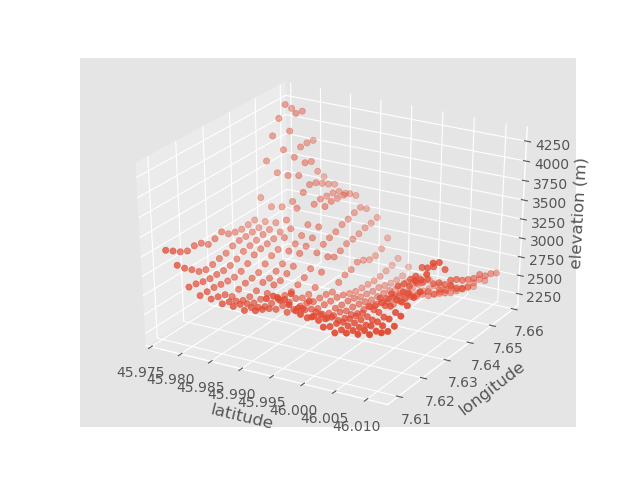

In [14]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xs = [coordinate[0] for coordinate in coordinates]
ys = [coordinate[1] for coordinate in coordinates]
zs = [elevation for elevation in elevations]
ax.scatter(xs, ys, zs)
ax.set_xlabel('latitude')
ax.set_ylabel('longitude')
ax.set_zlabel('elevation (m)')
plt.show()

##### Finally we export everything into an .csv file.

In [15]:
import pandas as pd

df=pd.DataFrame(data={'Latitudes':xs,'Longitudes':ys,'Elevations':zs})
df.to_csv("./GeoLocations.csv",sep=',',index=False)
